# Semeval Analysis
## Stance detection with Semeval 2016
#### http://alt.qcri.org/semeval2016/task6/

In [7]:

#===
 import Pkg; Conda.add("Nltk", :hd)
 env = :hd
 Conda.add("Nltk", env)
===#

ENV["PYTHON"] = "/usr/bin/python3"
using Pkg
Pkg.build("PyCall")

using PyCall

@pyimport nltk.stem as NLTK_STEM
@pyimport nltk.corpus as NLTK_CORPUS;


   Building Conda ─→ `~/.julia/packages/Conda/3rPhK/deps/build.log`
   Building PyCall → `~/.julia/packages/PyCall/zqDXB/deps/build.log`


In [32]:

using ProgressMeter
using DataFrames
using ScikitLearn
using JSON
using CSV
using PyCall
using Plots
using Conda
using StatsBase

using ScikitLearn
# pyimport_conda("sklearn", "scikit-learn")

NB = pyimport("sklearn.naive_bayes")
METRICS = pyimport("sklearn.metrics")

@pyimport nltk.stem as NLTK_STEM
@pyimport nltk.corpus as NLTK_CORPUS


include("../src/modelHDSparse.jl");


In [24]:

#===========================
    Load files
===========================#

fileTrain = "data/semEval/trainSemeval.csv"
fileTest = "data/semEval/testSemeval.csv"

dfTrain = CSV.read(fileTrain)
rename!(dfTrain, [:ID,:Tweet, :Target, :Stance, :OpinionsTowards, :Sentiment])
dfTest = CSV.read(fileTest)
rename!(dfTest, [:ID1,:ID2, :Target,:Tweet, :Stance])
dfTest[!,:Sentiment] = map(i -> i, 1:size(dfTest, 1))
dfTest[!,:OpinionsTowards] = map(i -> i, 1:size(dfTest, 1));


In [27]:
#===========================
    basic NLP from scratch
============================#

stopWords = NLTK_CORPUS.stopwords.words("english") 
filterWords = vcat([""], stopWords)

stemmer = NLTK_STEM.SnowballStemmer("english")

function largestSentenceOnly(corpus)
    maxCorpus = maximum(map(c -> length(c), corpus))
    for c in corpus
        if length(c) == maxCorpus
            return c
        end
    end
end


function parseTxt2BoW(text)
    # 1. decompose into sentences
    # 2. sentences -> Nag of Words
    
    function lowerCase(wrd)
       try
            lowercase(wrd) |> 
                (W -> filter(s -> !(s in ['\"']), W)) |>  # , '-', '+', '~'
                    stemmer.stem
        catch # found strange characters in dataset, maybe emoticons? '\x90','\xa2','\xb4','\xa0','\xb4','\xd3'
            wrd
        end
    end
    
    function massageText(wrds)
        # filter words
        wrds = filter(w -> !(w in filterWords), wrds)
        # filter words with symbols
        filter(w -> true, wrds) |> # !(w[1] in ['#', '@']), wrds)
            (W -> map(w -> lowerCase(w), W))
    end
    
    
    split(text, ['.','!','?']) |> 
        (txt -> map(t -> (split(t, [' ',',','/','\'',';',':',]) |> massageText), 
                    txt)) |> #largestSentenceOnly |>
        (T -> vcat(T...)) |>
        (T -> filter(x -> x != "", T))
end



parseTxt2BoW (generic function with 1 method)

In [29]:

#===
    Test parser on real tweets
===#

for (i,t) in enumerate(dfTrain[!,:Tweet])
    try
        parseTxt2BoW(t)
    catch
        println("bug in train: ", i)
    end
end

for (i,t) in enumerate(dfTest[!,:Tweet])
    try
        parseTxt2BoW(t)
    catch
        println("bug in test: ", i)
    end
end

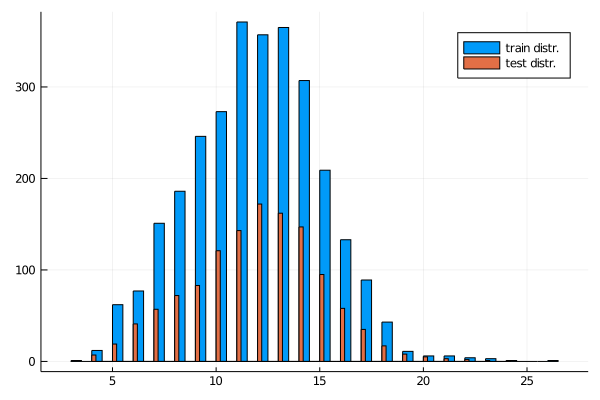

In [52]:
#===
    Used to fined tuned the SDR model
===#

lengthsTrain = map(t -> length(vcat(parseTxt2BoW(t)...)), dfTrain[!,:Tweet])  
lengthsTest = map(t -> length(vcat(parseTxt2BoW(t)...)), dfTest[!,:Tweet])

histogram(lengthsTrain, bins=100, label="train distr.")
histogram!(lengthsTest, bins=100, label="test distr.")


In [35]:


function getF1Scores(yTest, yClassified)
    #===
        fmacroT and fmicroT for "main classes"
        F-microT  was  used  as the bottom-line evaluation metric
        in the SemEval-2016 shared task  on stance detection
    ===#    
    f1Macro = METRICS.f1_score(yTest, yClassified, average="macro")
    f1Micro = METRICS.f1_score(yTest, yClassified, average="micro")
    
    idcesFavor = filter(i -> yTest[i] == classes["FAVOR"], 1:length(yTest)) 
    idcesAgainst = filter(i -> yTest[i] == classes["AGAINST"], 1:length(yTest))
    idcesNone = filter(i -> yTest[i] == classes["NONE"], 1:length(yTest))
    
    fFavorMacro = METRICS.f1_score(map(i -> yTest[i], idcesFavor), 
                                   map(i -> yClassified[i], idcesFavor), average="macro")
    fAgainstMacro = METRICS.f1_score(map(i -> yTest[i], idcesAgainst),
                                     map(i -> yClassified[i], idcesAgainst), average="macro")
    fNoneMacro = METRICS.f1_score(map(i -> yTest[i], idcesNone),
                                  map(i -> yClassified[i], idcesNone), average="macro")
    
    fFavorMicro = METRICS.f1_score(map(i -> yTest[i], idcesFavor),
                                   map(i -> yClassified[i], idcesFavor), average="micro")
    fAgainstMicro = METRICS.f1_score(map(i -> yTest[i], idcesAgainst),
                                     map(i -> yClassified[i], idcesAgainst), average="micro")
    fNoneMicro = METRICS.f1_score(map(i -> yTest[i], idcesNone),
                                  map(i -> yClassified[i], idcesNone), average="micro")

    Dict(:fMacroT => (fFavorMacro + fAgainstMacro) / 2,
         :fMicroT => (fFavorMicro + fAgainstMicro) / 2,
         #:fMacroT => (fFavorMacro + fAgainstMacro + fNoneMacro) / 3,
         #:fMicroT => (fFavorMicro + fAgainstMicro + fNoneMicro) / 3
    )
end



getF1Scores (generic function with 1 method)

### Encoding

In [37]:


function encoderHD(dicSDMs,
                   dicModelEncoding::Dict{Symbol,Dict{Symbol,Int64}},
                   dicData::Dict{Symbol,Array{String,1}})
     [(k = kv[1];
       ws = kv[2];
       vcat(map(w -> HDSparse.encodeOnTheFly(dicSDMs, dicModelEncoding[k], string(k, "_", w)), ws)...))
      for kv in dicData] |>
                HDSparse.superposition
end


function myDataModel(dfRow::DataFrameRow)
    
    vecBoWs = vcat(parseTxt2BoW(dfRow[:Tweet])...)
    
    Dict(:Target => [dfRow[:Target]],
         :Tweet => vecBoWs,
         #:biGrams => [string(sort([vecBoWs[i],vecBoWs[i-1]])) for i=3:length(vecBoWs)],
         #:biGramsSkip1 => [string(sort([vecBoWs[i],vecBoWs[i-2]])) for i=3:length(vecBoWs)],
         #:triGrams => [string(sort([vecBoWs[i],vecBoWs[i-1], vecBoWs[2-1]])) for i=3:length(vecBoWs)])
        )
end


function sparse2Dense(sparseVec)
    """
        Utility to convert into classifiable format.
    """
    v = zeros(n)
    for i in sparseVec.nzind
         v[i] = 1
    end
    v
end


# length of sdms
n = 10000

# We build SDRs dictionary "as you go"
dicSDMs = Dict()

# this is a fine tuned weighting with good classificaiton performance
wTxt, wTag, wTarget = 1, 1, 13 

dicModelEncoding = Dict(:Target => Dict(:N => n, :W => wTarget),
                        :Tweet => Dict(:N => n, :W => wTxt), 
                        :biGrams => Dict(:N => n, :W => wTxt),
                        :biGramsSkip1 => Dict(:N => n, :W => wTxt),
                        :triGrams => Dict(:N => n, :W => wTxt));


sparse2Dense (generic function with 1 method)

## Classification Results;
#### Randomness in the classification but high score for Naive Bayes!

In [49]:

#==================================
    Test SDRs + choose best model
==================================#


classes = unique(map(w -> w, dfTrain[!,:Stance]))
classes = Dict([classes[i] => i-1 for i = 1:length(classes)])
dic = StatsBase.countmap(map(w -> w, dfTrain[!,:Stance]))


my_clf = NB.BernoulliNB()


dicTestSDR = Dict()
scoresF1, scores, f1Micro, f1Macro = [], [], [], []

for i=1:2

    println(i)
    
    dicSDMs = Dict()
    #===#
    yTrain = map(c -> classes[c], dfTrain[!,:Stance])
    xTrain = 
        @showprogress map(i -> (dicData = myDataModel(dfTrain[i, :]);
                                encoderHD(dicSDMs, dicModelEncoding, dicData)),
                          1:size(dfTrain)[1])
    yTest = map(c -> classes[c], dfTest[!,:Stance])
    xTest = 
        @showprogress map(i -> (dicData = myDataModel(dfTest[i, :]);
                                encoderHD(dicSDMs, dicModelEncoding, dicData)),
                          1:size(dfTest)[1])
    #===#
    vv = map(sparse2Dense, xTrain)
    println("avg cardinal: ", sum(map(v -> sum(v), vv)) / length(vv))
    my_clf.fit(vv, yTrain) 
    vv = map(sparse2Dense, xTest)
    y = my_clf.predict(vv)
    score = sum(map(i -> y[i] == yTest[i], 1:length(y))) / length(y)
    append!(scores, score)
    println("precision: ", score)
    f1 = METRICS.f1_score(yTest, y, average="macro")
    append!(scoresF1, f1)
    println("f1: ", f1)
    f1Dict = getF1Scores(yTest, y)
    println("Metrics for competition:")
    JSON.json(f1Dict, 4) |> println
    # append!(f1Micro, f1Dict[:fMicro])
    # append!(f1Macro, f1Dict[:fMacro])
    dicTestSDR[i] = dicSDMs
    
end


1


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


avg cardinal: 24.0308853809197
precision: 0.6517213771016813
f1: 0.45182145209504987
Metrics for competition:
{
    "fMicroT": 0.6976421604711078,
    "fMacroT": 0.3467475937482202
}

2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


avg cardinal: 24.22443376801647
precision: 0.6437149719775821
f1: 0.44696068453233445
Metrics for competition:
{
    "fMicroT": 0.6906491534781009,
    "fMacroT": 0.26511226393703713
}



###    Scores Discussion


#### BEST SCORE with Naive Bayes
#####
##### precision=>65.33
##### F-microT=>70.46
##### F-macroT=>34.88
#####
##### F-microT and F-macroT as specified in : "A dataset for detecting stances in Tweets" (Mohammad, Kirichenko, ...)
##### http://www.saifmohammad.com/WebDocs/StarSem2016-stance-tweets.pdf
#####
##### article
##### fMacroT=>59.08
##### fMicroT=>70.32
#####
##### competition winning
##### fMacroT=>56.04
##### fMicroT=>67.82

